Explanations regarding the evaluation are at the bottom

In [1]:
import math
import sys
import numpy as np

# flatten lists
from functools import reduce
from operator import iconcat

import random


'''
This function can be used for importing the corpus.
Parameters: path_to_file: string; path to the file containing the corpus
Returns: list of list; the first layer list contains the sentences of the corpus;
    the second layer list contains tuples (token,label) representing a labelled sentence
'''
def import_corpus(path_to_file):
    sentences = []
    sentence = []
    f = open(path_to_file)

    while True:
        line = f.readline()
        if not line: break

        line = line.strip()
        if len(line) == 0:
            sentences.append(sentence)
            sentence = []
            continue

        parts = line.split(' ')
        sentence.append((parts[0], parts[-1]))

    f.close()
    return sentences




class MaxEntModel(object):
    # training corpus
    corpus = None
    
    # (numpy) array containing the parameters of the model
    # has to be initialized by the method 'initialize'
    theta = None
    
    # dictionary containing all possible features of a corpus and their corresponding index;
    # has to be set by the method 'initialize'; hint: use a Python dictionary
    feature_indices = None
    
    # set containing a list of possible lables
    # has to be set by the method 'initialize'
    labels = None
    
    
    cond_normalization_factor_memoization = {}
    
    # number of words used in training so far
    training_words_number = 0
    
    START_LABEL = '<START>'
    
    
    # Exercise 1 a) ###################################################################
    def initialize(self, corpus):
        '''
        Initialize the maximun entropy model, i.e., build the set of all features, the set of all labels
        and create an initial array 'theta' for the parameters of the model.
        Parameters: corpus: list of list representing the corpus, returned by the function 'import_corpus'
        '''
        self.corpus = corpus

        # get set of words
        words = list(map(lambda sentence: list(map(lambda pair: pair[0], sentence)), corpus))
        words = set(reduce(iconcat, words, []))

        # get set of labels
        labels = list(map(lambda sentence: list(map(lambda pair: pair[1], sentence)), corpus))
        labels = set(reduce(iconcat, labels, []))
        labels.add(MaxEntModel.START_LABEL)
        
        self.labels = labels        
        
        self.feature_indices = {}

        index = 0

        for word in words:
            for tag in labels:
                self.feature_indices[(word, tag)] = index
                index += 1
        
        for prev in labels:
            for curr in labels:
                self.feature_indices[(prev, curr)] = index
                index += 1
        
        self.theta = np.ones(index)
    
    
    # Exercise 1 b) ###################################################################
    def get_active_features(self, word, label, prev_label):
        '''
        Compute the vector of active features.
        Parameters: word: string; a word at some position i of a given sentence
                    label: string; a label assigned to the given word
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing only zeros and ones.
        '''
        
        active_features = {(word, label), (prev_label, label)}
        
        active_features_vector = np.zeros(len(self.theta))
        
        for feature in active_features:
            # if the feature is present in the training features
            if feature in self.feature_indices:
                active_features_vector[self.feature_indices[feature]] = 1
        
        return active_features_vector



    # Exercise 2 a) ###################################################################
    def cond_normalization_factor(self, word, prev_label):
        '''
        Compute the normalization factor 1/Z(x_i).
        Parameters: word: string; a word x_i at some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: float
        '''
        
        # we use memoization to avoid recalculating the normalization factor
        if (word, prev_label) in self.cond_normalization_factor_memoization:
            return self.cond_normalization_factor_memoization[(word, prev_label)]
        
        z = 0
        for label in self.labels:
            exponent = np.dot(self.theta, self.get_active_features(word, label, prev_label))
            z += math.e ** exponent
            
        factor = 1 / z
        
        self.cond_normalization_factor_memoization[(word, prev_label)] = factor
        
        return factor
        
    
    # Exercise 2 b) ###################################################################
    def conditional_probability(self, label, word, prev_label):
        '''
        Compute the conditional probability of a label given a word x_i.
        Parameters: label: string; we are interested in the conditional probability of this label
                    word: string; a word x_i some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: float
        '''
        
        exponent = np.dot(self.theta, self.get_active_features(word, label, prev_label))
        return self.cond_normalization_factor(word, prev_label) * math.e ** exponent    
    
    
    
    # Exercise 3 a) ###################################################################
    def empirical_feature_count(self, word, label, prev_label):
        '''
        Compute the empirical feature count given a word, the actual label of this word and the label of the previous word.
        Parameters: word: string; a word x_i some position i of a given sentence
                    label: string; the actual label of the given word
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing the empirical feature count
        '''
        
        return self.get_active_features(word, label, prev_label)    
    
    
    
    # Exercise 3 b) ###################################################################
    def expected_feature_count(self, word, prev_label):
        '''
        Compute the expected feature count given a word, the label of the previous word and the parameters of the current model
        (see variable theta)
        Parameters: word: string; a word x_i some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: (numpy) array containing the expected feature count
        '''
        
        expected = np.zeros(len(self.theta))
        
        for label in self.labels:
            active_features = self.get_active_features(word, label, prev_label)
            conditional_probability = self.conditional_probability(label, word, prev_label)
            
            expected = expected + np.dot(conditional_probability, active_features)
            
        return expected
    
    
    # Exercise 4 a) ###################################################################
    def parameter_update(self, word, label, prev_label, learning_rate):
        '''
        Do one learning step.
        Parameters: word: string; a randomly selected word x_i at some position i of a given sentence
                    label: string; the actual label of the selected word
                    prev_label: string; the label of the word at position i-1
                    learning_rate: float
        '''
        
        empirical_count = self.empirical_feature_count(word, label, prev_label)
        expected_count = self.expected_feature_count(word, prev_label)
        
        self.theta += learning_rate * (empirical_count - expected_count)
        self.cond_normalization_factor_memoization = {}
        
    
    
    # Exercise 4 b) ###################################################################
    def train(self, number_iterations, learning_rate=0.1):
        '''
        Implement the training procedure.
        Parameters: number_iterations: int; number of parameter updates to do
                    learning_rate: float
        '''
                    
        for sentence in self.corpus:
            last_label = MaxEntModel.START_LABEL
            for word, label in sentence:
                self.parameter_update(word, label, last_label, learning_rate)
                self.training_words_number += 1
                number_iterations -= 1
                if number_iterations == 0:
                    return
    
    
    # Exercise 4 c) ###################################################################
    def predict(self, word, prev_label):
        '''
        Predict the most probable label of the word referenced by 'word'
        Parameters: word: string; a word x_i at some position i of a given sentence
                    prev_label: string; the label of the word at position i-1
        Returns: string; most probable label
        '''
        most_probable_lable = None
        greatest_probability = 0
        
        for label in self.labels:
            label_probability = self.conditional_probability(label, word, prev_label)
            if label_probability >= greatest_probability:
                greatest_probability = label_probability
                most_probable_lable = label
                
        return most_probable_lable
    
    
    # Exercise 5 a) ###################################################################
    def empirical_feature_count_batch(self, sentences):
        '''
        Predict the empirical feature count for a set of sentences
        Parameters: sentences: list; a list of sentences; should be a sublist of the list returnd by 'import_corpus'
        Returns: (numpy) array containing the empirical feature count
        '''
        empirical_feature_sum = np.zeros(len(self.feature_indices))
        
        for sentence in sentences:
            prev_label = MaxEntModel.START_LABEL
            for word, label in sentence:
                empirical_feature_sum = empirical_feature_sum + self.empirical_feature_count(word, label, prev_label)
                prev_label = label
                
        return empirical_feature_sum
    
    
    # Exercise 5 a) ###################################################################
    def expected_feature_count_batch(self, sentences):
        '''
        Predict the expected feature count for a set of sentences
        Parameters: sentences: list; a list of sentences; should be a sublist of the list returnd by 'import_corpus'
        Returns: (numpy) array containing the expected feature count
        '''
        
        expected_feature_sum = np.zeros(len(self.feature_indices))
        
        for sentence in sentences:
            prev_label = MaxEntModel.START_LABEL
            for word, label in sentence:
                expected_feature_sum = expected_feature_sum + self.expected_feature_count(word, prev_label)
                prev_label = label
                
        return expected_feature_sum
        
    
    
    # Exercise 5 b) ###################################################################
    def train_batch(self, number_iterations, batch_size, learning_rate=0.1):
        '''
        Implement the training procedure which uses 'batch_size' sentences from to training corpus
        to compute the gradient.
        Parameters: number_iterations: int; number of parameter updates to do
                    batch_size: int; number of sentences to use in each iteration
                    learning_rate: float
        '''
        
        for _ in range(number_iterations):
            for sentence in random.sample(self.corpus, batch_size):
                last_label = MaxEntModel.START_LABEL
                for word, label in sentence:
                    self.parameter_update(word, label, last_label, learning_rate)
                    self.training_words_number += 1
    

In [2]:
corpus = import_corpus('corpus_pos.txt')
# print(corpus)

In [3]:
maxent = MaxEntModel()
maxent.initialize(corpus)
print('|Theta| == ', len(maxent.theta))
print('Labels: ', maxent.labels)

|Theta| ==  571458
Labels:  {'TO', '<START>', 'WP$', 'RBS', 'WRB', ':', 'NNPS', '-RRB-', '$', 'PDT', 'RP', 'WDT', '.', 'VBG', 'RB', 'VBZ', 'JJR', 'NN', 'JJS', 'EX', 'JJ', 'NNP', 'VBN', 'RBR', 'VBD', 'PRP', ',', 'NNS', "''", '-NONE-', 'MD', 'IN', 'VB', 'FW', 'CD', 'UH', 'LS', 'VBP', 'POS', 'SYM', 'PRP$', '-LRB-', '``', 'CC', 'DT', 'WP'}


In [4]:
test_word, test_label, test_prev_label = ('starters', 'NNS', 'IN')
s = np.sum(maxent.get_active_features(test_word, test_label, test_prev_label))
if s != 2:
    print('Error: ', s)

In [5]:
z = maxent.cond_normalization_factor(test_word, test_prev_label)
print(z)

0.0029420713747089714


In [6]:
p = maxent.conditional_probability("-NONE-", test_word, test_prev_label)
print(p)

0.021739130434782605


In [7]:
enp = maxent.empirical_feature_count(test_word, test_label, test_prev_label)
exp = maxent.expected_feature_count(test_word, test_prev_label)
print(enp, exp)
print(np.sum(enp))
print(np.sum(exp))

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
2.0
1.9999999999999996


In [8]:
maxent.train(10)
print(np.sum(maxent.theta))

571458.0


In [9]:
print(maxent.predict(test_word, test_prev_label))

WP


In [10]:
emp = maxent.empirical_feature_count_batch(corpus[:2])
print(np.sum(emp))

62.0


In [11]:
exp = maxent.expected_feature_count_batch(corpus[:2])
print(np.sum(exp))

62.0


In [12]:
maxent.train_batch(1, 1)
print(np.sum(maxent.theta))

571458.0


In [13]:
def get_accuracy(model, test_set):
    hits = 0
    total = 0

    for sentence in test_set:
        prev_label = MaxEntModel.START_LABEL
        for word, label in sentence:
            prediction = model.predict(word, prev_label)
        
            total += 1
            if prediction == label:
                hits += 1
            
            prev_label = label

    return hits/total
    

# Exercise 5 c) ###################################################################
    
# split the corpus into training and test set
random.shuffle(corpus)
training_set = corpus[:int(len(corpus) * 0.90)]
test_set = corpus[int(len(corpus) * 0.90):]

A = MaxEntModel()
A.initialize(training_set)

B = MaxEntModel()
B.initialize(training_set)

N = 20
A.train(N)
B.train_batch(N, 1)

In [14]:
accuracy_A = get_accuracy(A, test_set[:10])
accuracy_B = get_accuracy(B, test_set[:10])

print(accuracy_A)
print(accuracy_B)

0.028368794326241134
0.3617021276595745



Bad key savefig.frameon in file /home/michele/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/michele/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/michele/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to g

0.0014184397163120566
0.0007914707388612134


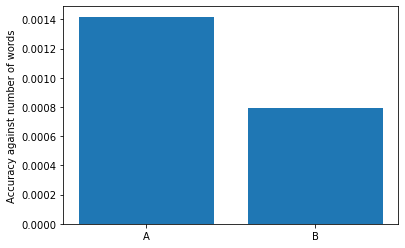

In [15]:
import matplotlib.pyplot as plt

print(accuracy_A/A.training_words_number)
print(accuracy_B/B.training_words_number)

results_list = [accuracy_A/A.training_words_number, accuracy_B/B.training_words_number]
    
plt.bar(['A', 'B'], results_list)
plt.ylabel('Accuracy against number of words')
plt.show()

I would expect the accuracy against number of words to be more or less the same for the two models. I guess this doesn't happen in the previous evaluation because the input data is not enough to have quality results.

The only true difference of the two training methods is that B (considering a large number of iterations) will consider the same sentences more than once, because the sentences are sampled randomly.

I couldn't use a larger amount of data because of the time complexity of this implementation of the model.